In [13]:
import pymongo 
import matplotlib
import string
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
# Connecting to MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017")

In [15]:
"""
queries all the tweets for a given database and collection
"""
def find_all_tweets(db_client, db_name, coll_name):
    db = db_client[db_name]
    collection = db[coll_name]
    query = {}
    projection = {'tweet': 1, 'date': 1, '_id': 0}
    tweets = collection.find(query, projection)
    # Defining and executing a query to obtain an aggregated list of tweets per year 
    pipeline = [{'$project': {
            'tweet': 1,
            'year': {'$year': {'$dateFromString': {'dateString': '$date'}}}}},
    {'$group': {
            '_id': '$year',
            'tweets': {'$push': '$tweet'},
            'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}]
    
    results = list(collection.aggregate(pipeline))
    
    return results 

In [22]:
popular_tweets = find_all_tweets(client, "local", "popular_tweets")

In [40]:
all_tweets = find_all_tweets(client, "local", "all_tweets")

In [27]:
"""
clean/process the queried db tweets
"""
def process_tweets(results):
    for result in results: 
        tweets = result['tweets'] 
        processed_tweets = []
        for tweet in tweets: 
            s = tweet.lower()
            s = s.translate(str.maketrans("", "", string.punctuation))
            s = re.sub(r'\d+', '', s)
            
            # Append the processed string to the output list
            processed_tweets.append(s)
    # Replace the original tweets with the processed tweets
    result['tweets'] = processed_tweets
    
    return results

In [28]:
processed_pop_tweets = process_tweets(popular_tweets)

In [41]:
processed_tweets = process_tweets(all_tweets)

In [30]:
"""
conduct sentiment analysis on tweets 
"""
def analyze_sentiment(results):
    # defining an empty dictionary 
    year_sentiment = {}
    
    for result in results:
        # define year and list of tweets 
        year = result['_id']
        tweets = result['tweets'] 
        
        # use VADER to keep track of avg compound scores for a given year 
        sentiment_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets] 
        year_sentiment[result['_id']] = (sum(sentiment_scores)/len(sentiment_scores)) * 100
        
    # Create a DataFrame from the dictionary
    yearly_df = pd.DataFrame(list(year_sentiment.items()), columns=['Year', 'Score'])

    return yearly_df 

In [31]:
pop_sentiment = analyze_sentiment(processed_pop_tweets)

In [42]:
sentiment = analyze_sentiment(processed_tweets)

In [33]:
def calc_sentiment(results):
    sentiment_list = []
    
    for result in results:
        # define year and list of tweets 
        year = result['_id']
        tweets = result['tweets'] 
        tweet_text = ' '.join(tweets)
        
        scores = analyzer.polarity_scores(tweet_text)
        
        # Extract the negative, positive, and neutral scores from the dictionary
        negative_score = scores["neg"]
        positive_score = scores["pos"]
        neutral_score = scores["neu"]
        
        # Calculate the percentage of negative, positive, and neutral sentiment in the text
        total_score = negative_score + positive_score + neutral_score
        negative_percentage = (negative_score / total_score) * 100
        positive_percentage = (positive_score / total_score) * 100
        
        # Create a dictionary with the year, positive and negative percentage
        sentiment_dict = {
            'year': year,
            'negative_percentage': - negative_percentage,
            'positive_percentage': positive_percentage,
            'score': (positive_score - negative_score) * 100}
        sentiment_list.append(sentiment_dict)
        
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(sentiment_list)
    
    return df

In [35]:
pop_sentiment

,Year,Score
0,2011,86.250000
1,2012,15.860000
2,2013,46.086667
3,2014,47.350606
4,2015,39.392366
5,2016,37.740744
6,2017,35.162918
7,2018,35.952955
8,2019,34.868758
9,2020,29.598773


In [36]:
pop_sentiment_precent = calc_sentiment(processed_pop_tweets)

In [37]:
pop_sentiment_precent

,year,negative_percentage,positive_percentage,score
0,2011,-0.000000,42.000000,42.0
1,2012,-11.700000,16.800000,5.1
2,2013,-4.004004,24.024024,20.0
3,2014,-4.000000,21.800000,17.8
4,2015,-5.805806,20.720721,14.9
5,2016,-8.000000,26.100000,18.1
6,2017,-9.509510,25.225225,15.7
7,2018,-9.300000,20.200000,10.9
8,2019,-9.600000,20.300000,10.7
9,2020,-10.300000,19.700000,9.4


In [43]:
sentiment_precent = calc_sentiment(processed_tweets)

In [48]:
# reading in the cpi data 
cpi = pd.read_csv('cpi-raw.csv')
cpi

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,2006,198.300,198.700,199.800,201.500,202.500,202.900,203.500,203.900,202.900,201.800,201.500,201.800,201.600,200.600,202.600
1,2007,202.416,203.499,205.352,206.686,207.949,208.352,208.299,207.917,208.490,208.936,210.177,210.036,207.342,205.709,208.976
2,2008,211.080,211.693,213.528,214.823,216.632,218.815,219.964,219.086,218.783,216.573,212.425,210.228,215.303,214.429,216.177
3,2009,211.143,212.193,212.709,213.240,213.856,215.693,215.351,215.834,215.969,216.177,216.330,215.949,214.537,213.139,215.935
4,2010,216.687,216.741,217.631,218.009,218.178,217.965,218.011,218.312,218.439,218.711,218.803,219.179,218.056,217.535,218.576
5,2011,220.223,221.309,223.467,224.906,225.964,225.722,225.922,226.545,226.889,226.421,226.230,225.672,224.939,223.598,226.280
6,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,229.594,228.850,230.338
7,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.957,232.366,233.548
8,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.736,236.384,237.088
9,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017,236.265,237.769


In [59]:
def sentiment_analysis_plot(df, title, cpi):
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()
    # Create barplot with % vs year
    ax1.bar(df['year'], df['positive_percentage'], color='green', alpha=0.5, label = 'positive %')
    ax1.bar(df['year'], df['negative_percentage'], color='red', alpha=0.5, label = 'negative %')
    # Set labels and titles
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment Percentage')
    ax2.set_ylabel('CPI')
    ax1.set_title(title)
    # Create lineplot with score vs year
    ax1.plot(df['year'], df['score'], color='black', linewidth=2, label = 'overall sentiment score')
    ax2.plot(cpi['Year'], cpi['Annual'], color='red', linewidth=2, label = 'annual cpi')
    # Set x-axis ticks
    plt.xticks(df['year'])
    ax1.legend()
    # Show the plot
    plt.show()

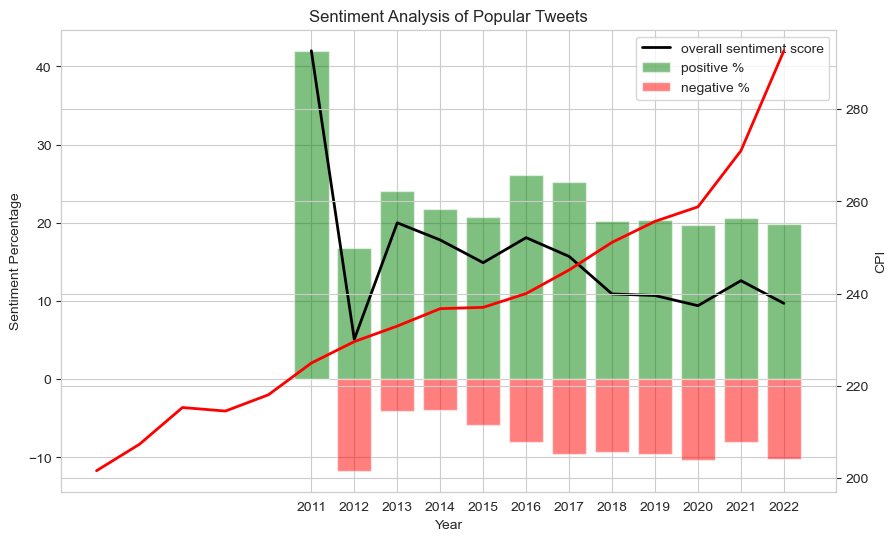

In [60]:
sentiment_analysis_plot(pop_sentiment_precent, "Sentiment Analysis of Popular Tweets", cpi)

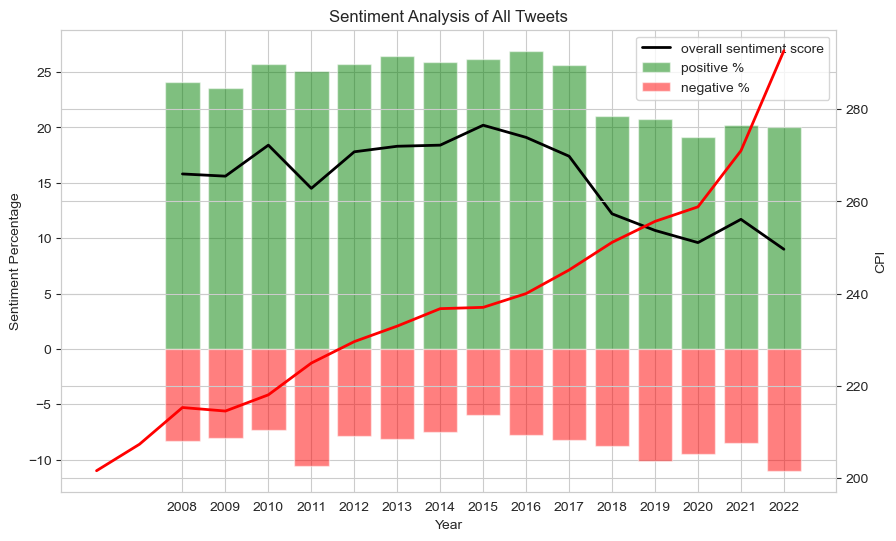

In [61]:
sentiment_analysis_plot(sentiment_precent, "Sentiment Analysis of All Tweets", cpi)

## Code Dump

In [ ]:
db = client["local"]
collection = db["popular_tweets"]

In [3]:
# TEST: Defining and executing a query to obtain all dates and tweets
query = {}
projection = {'tweet': 1, 'date': 1, '_id': 0}
tweets = collection.find(query, projection)

In [4]:
# Defining and executing a query to obtain an aggregated list of tweets per year 
pipeline = [{'$project': {
            'tweet': 1,
            'year': {'$year': {'$dateFromString': {'dateString': '$date'}}}}},
    {'$group': {
            '_id': '$year',
            'tweets': {'$push': '$tweet'},
            'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}]

results = list(collection.aggregate(pipeline))

In [6]:
results

[{'_id': 2011,
  'tweets': ['Small businesses help drive America’s economic growth and create new jobs. When our small businesses do well, then America does well.'],
  'count': 1},
 {'_id': 2012,
  'tweets': ['New energy cannot be created and high grade energy is being destroyed.  An economy based on endless growth is...',
   "FACT: Before President Obama took office, the economy was losing 800,000 jobs a month. Now, we've seen 31 consecutive months of job growth.",
   'President Obama: "At a time when our economy is still recovering from the Great Recession, our top priority has to be jobs and growth."',
   "“We believe in the strivers, the dreamers, the risk takers. We know they've always been the driving force behind our economic growth.”"],
  'count': 4},
 {'_id': 2013,
  'tweets': ["Our engine of economic growth: Strengthening the middle class. Share Obama's plan to keep us moving forward:  http://t.co/0Kfa7Ens",
   'Obama: “It is our generation’s task ... to reignite the true eng

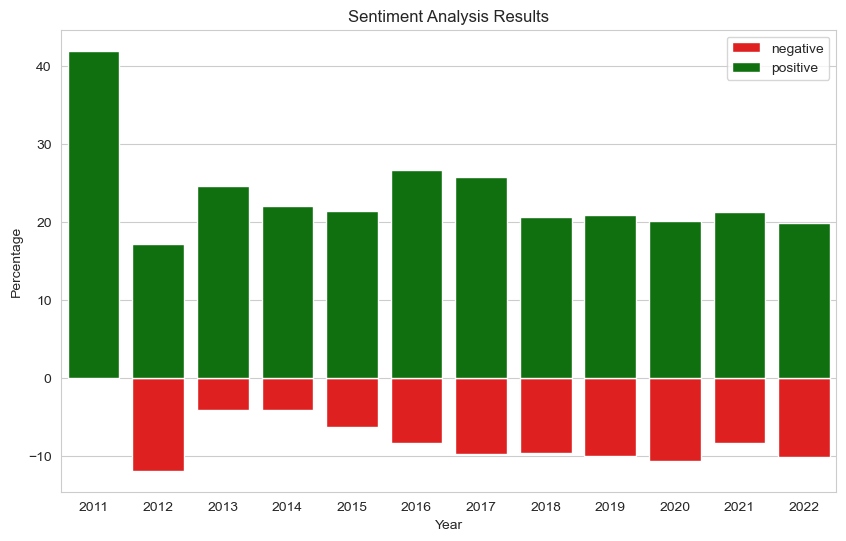

In [10]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# define colors 
colors = ["red", "green"]
custom_palette = sns.set_palette(sns.color_palette(colors))

# Create the stacked bar chart using Seaborn
sns.barplot(data=df, x='year', y='negative_percentage', color='red', ax=ax1, label='negative')
sns.barplot(data=df, x='year', y='positive_percentage', color='green', ax=ax1, label='positive')

#sns.lineplot(data=df, x='year', y='score', color='black', ax=ax1)

# Set the x-axis limits to match
ax.set_xlim(df['year'].min(), df['year'].max())

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Results')
plt.legend()

# Show the plot
plt.show()

In [5]:
for result in results: 
    tweets = result['tweets'] 
    
    processed_tweets = []
    for tweet in tweets: 
        s = tweet.lower()
        s = s.translate(str.maketrans("", "", string.punctuation))
        s = re.sub(r'\d+', '', s)
        
        # Append the processed string to the output list
        processed_tweets.append(s)
    
     # Replace the original tweets with the processed tweets
    result['tweets'] = processed_tweets
    
print(results)


[{'_id': 2011, 'tweets': ['small businesses help drive america’s economic growth and create new jobs when our small businesses do well then america does well'], 'count': 1}, {'_id': 2012, 'tweets': ['new energy cannot be created and high grade energy is being destroyed  an economy based on endless growth is', 'fact before president obama took office the economy was losing  jobs a month now weve seen  consecutive months of job growth', 'president obama at a time when our economy is still recovering from the great recession our top priority has to be jobs and growth', '“we believe in the strivers the dreamers the risk takers we know theyve always been the driving force behind our economic growth”'], 'count': 4}, {'_id': 2013, 'tweets': ['our engine of economic growth strengthening the middle class share obamas plan to keep us moving forward  httptcokfaens', 'obama “it is our generation’s task  to reignite the true engine of america’s economic growth—a rising thriving middle class” sotu',

In [6]:
analyzer = SentimentIntensityAnalyzer()

# defining an empty dictionary 
year_sentiment = {}

for result in results:
    # define year and list of tweets 
    year = result['_id']
    tweets = result['tweets'] 
    
    # use VADER to keep track of avg compound scores for a given year 
    sentiment_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets] 
    year_sentiment[result['_id']] = (sum(sentiment_scores)/len(sentiment_scores)) * 100

# Create a DataFrame from the dictionary
yearly_df = pd.DataFrame(list(year_sentiment.items()), columns=['Year', 'Score'])

# Print the resulting DataFrame
print(yearly_df)

    Year      Score
0   2011  86.250000
1   2012  15.860000
2   2013  46.316667
3   2014  47.009091
4   2015  38.896237
5   2016  37.649676
6   2017  35.009495
7   2018  35.623136
8   2019  34.797727
9   2020  29.509621
10  2021  40.821348
11  2022  30.640288


In [7]:
sentiment_list = []

for result in results:
    # define year and list of tweets 
    year = result['_id']
    tweets = result['tweets'] 
    tweet_text = ' '.join(tweets)
    
    scores = analyzer.polarity_scores(tweet_text)
    
    # Extract the negative, positive, and neutral scores from the dictionary
    negative_score = scores["neg"]
    positive_score = scores["pos"]
    neutral_score = scores["neu"]

    # Calculate the percentage of negative, positive, and neutral sentiment in the text
    total_score = negative_score + positive_score + neutral_score
    negative_percentage = (negative_score / total_score) * 100
    positive_percentage = (positive_score / total_score) * 100
 
    # Create a dictionary with the year, positive and negative percentage
    sentiment_dict = {
        'year': year,
        'negative_percentage': - negative_percentage,
        'positive_percentage': positive_percentage,
        'score': (positive_score - negative_score) * 100}
    sentiment_list.append(sentiment_dict)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(sentiment_list)

print(df)

    year  negative_percentage  positive_percentage  score
0   2011            -0.000000            42.000000   42.0
1   2012           -11.900000            17.200000    5.3
2   2013            -4.100000            24.700000   20.6
3   2014            -4.100000            22.100000   18.0
4   2015            -6.300000            21.400000   15.1
5   2016            -8.400000            26.700000   18.3
6   2017            -9.800000            25.800000   16.0
7   2018            -9.600000            20.700000   11.1
8   2019           -10.000000            20.900000   10.9
9   2020           -10.600000            20.200000    9.6
10  2021            -8.291708            21.278721   13.0
11  2022           -10.200000            19.900000    9.7
